In [223]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.tree as skt
import sklearn.preprocessing as skp
import networkx as nx

In [372]:
def read_data():
    df = pd.read_csv("lcc.txt", names='label barrierE barrierS excessbarrierE'.split(), sep="\s+")
    cols = 'R1 R2 R3 R4 X Y'.split()
    paircols = []
    df[cols] = q.label.str.split("_", expand=True)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            paircols.append(cols[i] + cols[j])
            #df[paircols[-1]] = np.amax(np.vstack((df[cols[i]].values, df[cols[j]].values)), axis=0)
    return df, cols, paircols
q, cols, paircols = read_data()
q

,label,barrierE,barrierS,excessbarrierE,R1,R2,R3,R4,X,Y
0,B_E_D_A_C_B,11.357081,14.213574,-2.856493,B,E,D,A,C,B
1,E_C_D_A_B_C,31.653424,26.617134,5.036290,E,C,D,A,B,C
2,A_B_E_A_C_C,35.131265,28.200011,6.931254,A,B,E,A,C,C
3,C_A_A_A_C_A,7.503506,0.806002,6.697505,C,A,A,A,C,A
4,C_B_E_A_C_C,30.364494,25.654902,4.709592,C,B,E,A,C,C
...,...,...,...,...,...,...,...,...,...,...
7495,E_E_E_E_B_D,27.828924,42.858887,-15.029963,E,E,E,E,B,D
7496,E_E_E_E_C_A,11.647841,28.682739,-17.034898,E,E,E,E,C,A
7497,E_E_E_E_C_B,21.424529,27.860305,-6.435777,E,E,E,E,C,B
7498,E_E_E_E_C_C,30.733898,38.185870,-7.451972,E,E,E,E,C,C


In [259]:
select = cols
enc_obj = skp.OneHotEncoder(drop="first").fit(q[select])
enc = enc_obj.transform(q[select])
enc

<7500x21 sparse matrix of type '<class 'numpy.float64'>'
	with 34625 stored elements in Compressed Sparse Row format>

In [369]:
def show_me(subset, target):
    enc = enc_obj.transform(subset[select])
    reg = skt.DecisionTreeRegressor(max_depth=3, min_samples_split=250, min_samples_leaf=100, criterion="mae", min_impurity_decrease=0.05)
    reg.fit(enc, subset[target])
    print (np.average(np.abs(reg.predict(enc) - subset[target])), np.abs(subset[target] - subset[target].values.mean()).mean())
    #f = plt.figure(figsize=(30, 20))
    #_ = skt.plot_tree(reg, max_depth=5)
    return reg
modelE = show_me(q, "barrierE")
modelS = show_me(q, "barrierS")
modelEe = show_me(q, "excessbarrierE")

5.163074087807427 12.095284050476076
7.4205712690313055 11.893948619003776
7.258579438944594 8.823410499456942


In [321]:
def explain(digit):
    query = np.zeros((21, 1))
    query[digit] = 1
    res = enc_obj.inverse_transform(query.T)[0]
    pos = np.where(res != "A")[0][0]
    colname = 'R_1 R_2 R_3 R_4 X Y'.split()[pos]
    Xs = ['\mathrm{F}', '\mathrm{Cl}', '\mathrm{Br}']
    Ys = '\mathrm{H} \mathrm{F} \mathrm{Cl} \mathrm{Br}'.split()
    Rs = '\mathrm{H} \mathrm{NO}_2 \mathrm{CN} \mathrm{CH}_3 \mathrm{NH}_2'.split()
    letters = 'BCDEF'
    pidx = letters.index(res[pos])
    if pos < 4:
        group = Rs[pidx]
    if pos == 4:
        group = Xs[pidx]
    if pos == 5:
        group = Ys[pidx]
    return "\mathrm{" + colname + "} = " + group
explain(10)

'\\mathrm{R_3} = \\mathrm{CN}'

The binary tree structure has 13 nodes and has the following tree structure:
3
node=0 test node: go to node 1 if X[:, 19] <= 0.5 else to node 8.
	node=1 test node: go to node 2 if X[:, 20] <= 0.5 else to node 5.
		node=2 test node: go to node 3 if X[:, 8] <= 0.5 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 17] <= 0.5 else to node 7.
			node=6 leaf node.
			node=7 leaf node.
	node=8 test node: go to node 9 if X[:, 17] <= 0.5 else to node 12.
		node=9 test node: go to node 10 if X[:, 8] <= 0.5 else to node 11.
			node=10 leaf node.
			node=11 leaf node.
		node=12 leaf node.

The binary tree structure has 13 nodes and has the following tree structure:
3
node=0 test node: go to node 1 if X[:, 20] <= 0.5 else to node 8.
	node=1 test node: go to node 2 if X[:, 19] <= 0.5 else to node 5.
		node=2 test node: go to node 3 if X[:, 3] <= 0.5 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 17] 

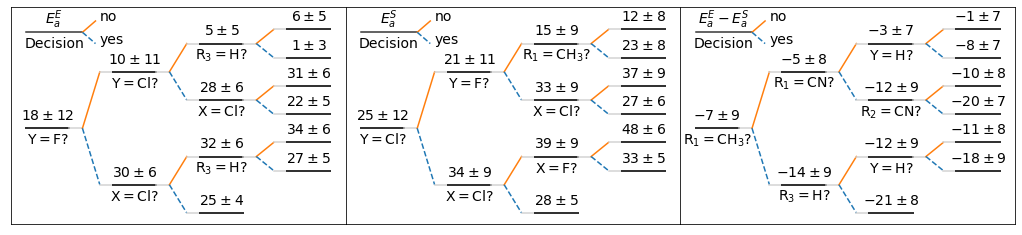

In [404]:
def vistree(tree, quantity, ax):
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    #ypos = [0,100,150,175,125,50, 25,75,-100,-50,-25,-75 ,-150]
    ypos = np.zeros(n_nodes)
    ##levelcounts = [] 
    #for level in range(max(node_depth)):
    #    levelcounts = 
    #for i in range(n_nodes):
        
    print (max(node_depth))
    for i in range(n_nodes):
        ax.plot((node_depth[i]*2, node_depth[i]*2+1), (ypos[i], ypos[i]), color="#333333", lw=2)
        mae = tree.impurity[i]
        value = tree.value[i][0,0]
        label = f'${value:5.0f} \pm {mae:5.0f}$'
        ax.annotate(s=label, xy=(node_depth[i]*2 + 0.5, ypos[i]+15), ha="center")
        if is_leaves[i]:
            print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            #plt.plot((node_depth[i]*2, node_depth[i]*2+1), (ypos[i], ypos[i]))
            ax.annotate(s="$" + explain(feature[i]) + "$?", xy=(node_depth[i]*2 + 0.5, ypos[i]-28), ha="center")
            print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))
            ypos[children_left[i]] = ypos[i] +  100/(2**node_depth[i])
            ypos[children_right[i]] = ypos[i] -  100/(2**node_depth[i])
            ax.plot((node_depth[i]*2+1, node_depth[i]*2+1.3), (ypos[i], ypos[i]), color="lightgrey")
            
            ax.plot((node_depth[i]*2+1.3, node_depth[i]*2+1.7), (ypos[i], ypos[children_left[i]]), color="C1")
            ax.plot((node_depth[i]*2+1.7, node_depth[i]*2+2), (ypos[children_left[i]], ypos[children_left[i]]), color="lightgrey")
            
            ax.plot((node_depth[i]*2+1.3, node_depth[i]*2+1.7), (ypos[i], ypos[children_right[i]]), color="C0", linestyle="--")
            ax.plot((node_depth[i]*2+1.7, node_depth[i]*2+2), (ypos[children_right[i]], ypos[children_right[i]]), color="lightgrey")
    print()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(-170, 215)
    
    legendy = 170
    ax.plot((0, 1.3), (legendy, legendy), '#333333')
    ax.annotate(s="Decision", xy=(0.65, legendy-28), ha="center")
    ax.annotate(s=quantity, xy=(0.65, legendy+15), ha="center")
    ax.plot((1.3, 1.6), (legendy, legendy+20), color="C1")
    ax.plot((1.3, 1.6), (legendy, legendy-20), color="C0", linestyle="--")
    ax.annotate(s="no", xy=(1.7, legendy+20), ha="left")
    ax.annotate(s="yes", xy=(1.7, legendy-20), ha="left")
    
f, axs = plt.subplots(1,3, figsize=(18,4))
plt.rcParams.update({'font.size': 14})
vistree(modelE.tree_, "$E_a^E$", axs[0])
vistree(modelS.tree_, "$E_a^S$", axs[1])
vistree(modelEe.tree_, "$E_a^E-E_a^S$", axs[2])
plt.subplots_adjust(wspace=0)
plt.savefig("decisiontree.pdf", bbox_inches="tight")

In [167]:
target = 'barrierE'
treed = q.copy()[('label %s R1 R2 R3 R4 X Y' % target).split()]
#q.groupby('X Y'.split()).mean()[target].reset_index()
treed['Q1'] = treed.Y.isin("C D".split())
print ("Q1", treed.groupby('Q1').mean()[target])

Q1 Q1
False     6.057501
True     29.401964
Name: barrierE, dtype: float64


In [178]:
#show_me(treed[treed.Q1])
q.groupby('X Y'.split()).mean()[target].reset_index()

,X,Y,barrierE
0,A,A,5.276674
1,A,B,8.737748
2,A,C,35.730363
3,A,D,34.337667
4,B,A,4.735795
5,B,B,6.911751
6,B,C,30.085263
7,B,D,28.668969
8,C,A,3.998161
9,C,B,6.684880


8.320704486816018 R3
12.207649299895277 R4
10.814079383322714 X
11.664429756261544 X


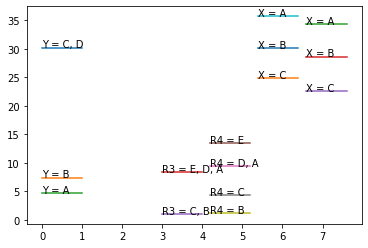

In [209]:
def get_split_level(df, target):
    max_spread = 0
    max_col = None
    for col in 'R1 R2 R3 R4 X Y'.split():
        means = df.groupby(col).mean()[target].values
        spread = max(means) - min(means)
        if spread > max_spread:
            max_spread = spread
            max_col = col
    return max_spread, max_col

def split_level(df, target, level, xval):
    means =  df.groupby(level).mean()[target].reset_index().sort_values(target, ascending=False)
    last_val = -1000
    done= []
    for i in range(len(means)):
        if i in done:
            continue
        labels = [means[level].values[i]]
        for j in range(i+1, len(means)):
            if np.abs(means[target].values[i] - means[target].values[j]) < INDISTINGUISHABLE:
                labels.append(means[level].values[j])
                done.append(j)
        yval = means[target].values[i]
        plt.plot((xval, xval+1), (yval, yval))
        
        labeltxt = ', '.join(labels)
        labeltxt = f'{level} = {labeltxt}'
        plt.annotate(labeltxt, xy=(xval, yval))
    return means

INDISTINGUISHABLE = 2.
spread, level = get_split_level(treed, target)
split_level(treed, target, level, 0)

shift = 1

for colval in sorted(treed[level].unique()):
    s = treed.query("Y == @colval")
    spread, level = get_split_level(s, target)
    print (spread, level)
    split_level(s, target, level, 2 + shift)
    shift += 1.2

   Y   barrierE  last_batch
0  C  30.243970           0
1  D  28.559958           0
2  B   7.444793           0
3  A   4.670210           0
0 1 1.6840121101452965
   X   barrierE  last_batch
0  A   5.276674           0
1  B   4.735795           0
2  C   3.998161           0
3  A   8.737748           1
4  B   6.911751           1
5  C   6.684880           1
6  A  35.034015           2
7  B  29.377116           2
8  C  23.794760           2
0 1 0.5408788947373475
0 2 1.2785131808918724
0 4 1.6350769767208169
0 5 1.4082055090284777
1 2 0.7376342861545249
1 5 1.9490844037658253
3 4 1.8259968474672368
4 5 0.22687146769233912


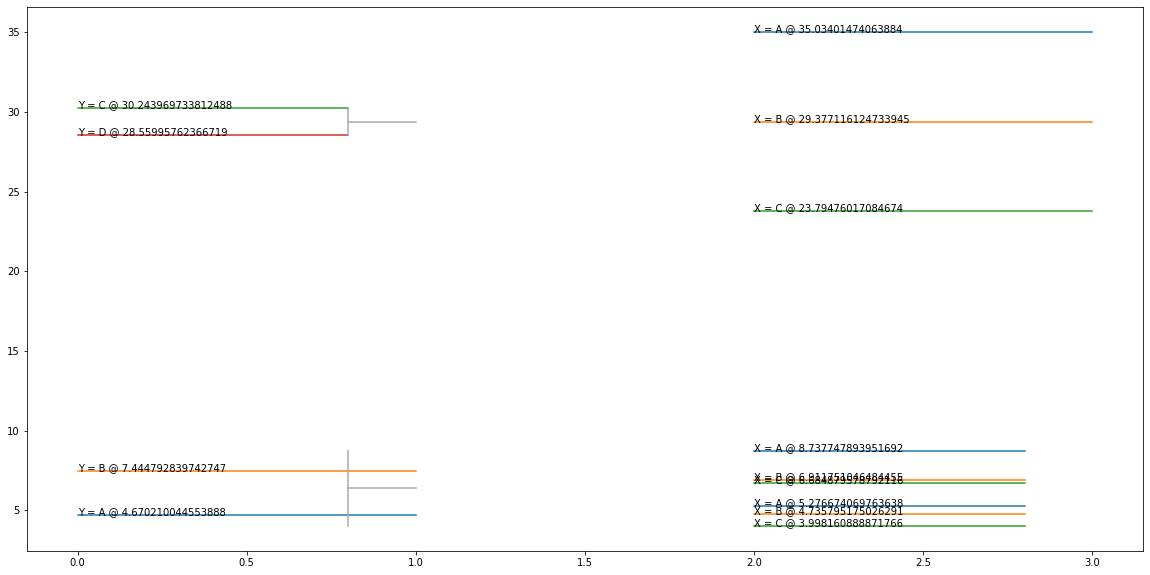

In [257]:
def split_level(df, target, level, xval):
    means =  df.groupby(level).mean()[target].reset_index().sort_values(target, ascending=False)
    for idx, row in means.iterrows():
        yval = row[target]
        barwidth = PLOT_BAR_LENGTH
        if len(np.where(np.abs(means[target].values - row[target]) < INDISTINGUISHABLE)[0]) > 1:
            barwidth = PLOT_BAR_LENGTH-PLOT_LEAVE_GROUP
        plt.plot((xval, xval+barwidth), (yval, yval), color=f'C{idx}')
        labeltxt = f'{level} = {row[level]} @ {yval}'
        plt.annotate(labeltxt, xy=(xval, yval))
    return means
def find_close(meanss, target):
    g = nx.Graph()
    for i in range(len(meanss)):
        g.add_node(i)
        for j in range(i+1, len(meanss)):
            if abs(meanss.iloc[i][target] - meanss.iloc[j][target]) < INDISTINGUISHABLE:
                print (i, j, abs(meanss.iloc[i][target] - meanss.iloc[j][target]))
                g.add_edge(i, j)
    return [_ for _ in nx.connected_components(g)]


INDISTINGUISHABLE = 2.
PLOT_LEAVE_GROUP = 0.2
PLOT_BAR_LENGTH = 1
groupID = 0
fig = plt.figure(figsize=(20, 10))
batches = [treed.copy()]
col = "Y"
group_begin = 
meanss = []
for bidx, batch in enumerate(batches):
    means = split_level(batch, target, col, 0)
    means['last_batch'] = bidx
    meanss.append(means)
last_groups = pd.concat(meanss).reset_index(drop=True)
print (last_groups)
close = find_close(last_groups, target)
for group in close:
    if len(group) == 1:
        continue
    else:
        mvals = [last_groups.iloc[_][target] for _ in group]
        min_mval = min(mvals)
        max_mval = max(mvals)
        mid_mval = (min_mval + max_mval)/2
        plt.plot((PLOT_BAR_LENGTH-PLOT_LEAVE_GROUP, PLOT_BAR_LENGTH-PLOT_LEAVE_GROUP), (min_mval, max_mval), color="darkgrey")
        plt.plot((PLOT_BAR_LENGTH-PLOT_LEAVE_GROUP, 1), (mid_mval, mid_mval), color="darkgrey")


batches = [last_df.query("Y=='A'"), last_df.query("Y=='B'"), last_df.query("Y=='C' or Y=='D'")]
col = "X"
meanss = []
for bidx, batch in enumerate(batches):
    means = split_level(batch, target, col, 2)
    means['last_batch'] = bidx
    meanss.append(means)
last_groups = pd.concat(meanss).reset_index(drop=True)
print (last_groups)
close = find_close(last_groups, target)
for group in close:
    if len(group) == 1:
        continue
    else:
        mvals = [last_groups.iloc[_][target] for _ in group]
        min_mval = min(mvals)
        max_mval = max(mvals)
        mid_mval = (min_mval + max_mval)/2
        plt.plot((PLOT_BAR_LENGTH-PLOT_LEAVE_GROUP, PLOT_BAR_LENGTH-PLOT_LEAVE_GROUP), (min_mval, max_mval), color="darkgrey")
        plt.plot((PLOT_BAR_LENGTH-PLOT_LEAVE_GROUP, 1), (mid_mval, mid_mval), color="darkgrey")
